In [69]:
from pathlib import Path
import sys

import pandas as pd

sys.path.append("..")

from src.utils.logger import setup_logger

LOG = setup_logger("tmpSeries", log_file="../logs/tmpSeries.log")

In [36]:
poor_gauges = pd.read_csv(
    "../res/top100_worst_fine_tune_gauges.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
poor_gauges.sort_values(by="lstm_nse_test", ascending=True, inplace=True)

In [ ]:
def check_gauge_location(
    gauge_id: str, discharge_dir: Path = Path("../res/hydro/Discharge")
) -> Path | None:
    """Check where a gauge_id is located and return the full file path.

    Args:
        gauge_id: The gauge ID to check
        discharge_dir: Path to the Discharge directory

    Returns:
        Path object to the CSV file if found, None if not found
    """
    locations = [
        ("full/decent", discharge_dir / "full" / "decent" / f"{gauge_id}.csv"),
        ("full/poor", discharge_dir / "full" / "poor" / f"{gauge_id}.csv"),
        ("partial/decent", discharge_dir / "partial" / "decent" / f"{gauge_id}.csv"),
        ("partial/poor", discharge_dir / "partial" / "poor" / f"{gauge_id}.csv"),
    ]

    for location_name, file_path in locations:
        if file_path.exists():
            LOG.info(f"Gauge {gauge_id} found in: {location_name} at {file_path}")
            return file_path

    LOG.warning(f"Gauge {gauge_id} not found in any location")
    return None


# Check the first gauge
gauge_id = str(poor_gauges.index[0])
file_path = check_gauge_location(gauge_id)
if file_path:
    print(f"Gauge {gauge_id} is located at: {file_path}")
    # Example: Read the file directly
    # df = pd.read_csv(file_path, parse_dates=["date"], index_col="date")
else:
    print(f"Gauge {gauge_id} not found")


2025-12-30 12:10:54 | INFO     | PhDLogger | tmpSeries | ℹ️  Gauge 19135 found in: full/decent


Gauge 19135 is located at: ../res/hydro/Discharge/full/decent/19135.csv


2025-12-30 14:24:49 | INFO     | PhDLogger | tmpSeries | ℹ️  Gauge 19135 found in: full/decent
2025-12-30 14:24:49 | INFO     | PhDLogger | tmpSeries | ℹ️  Gauge 78261 found in: full/decent


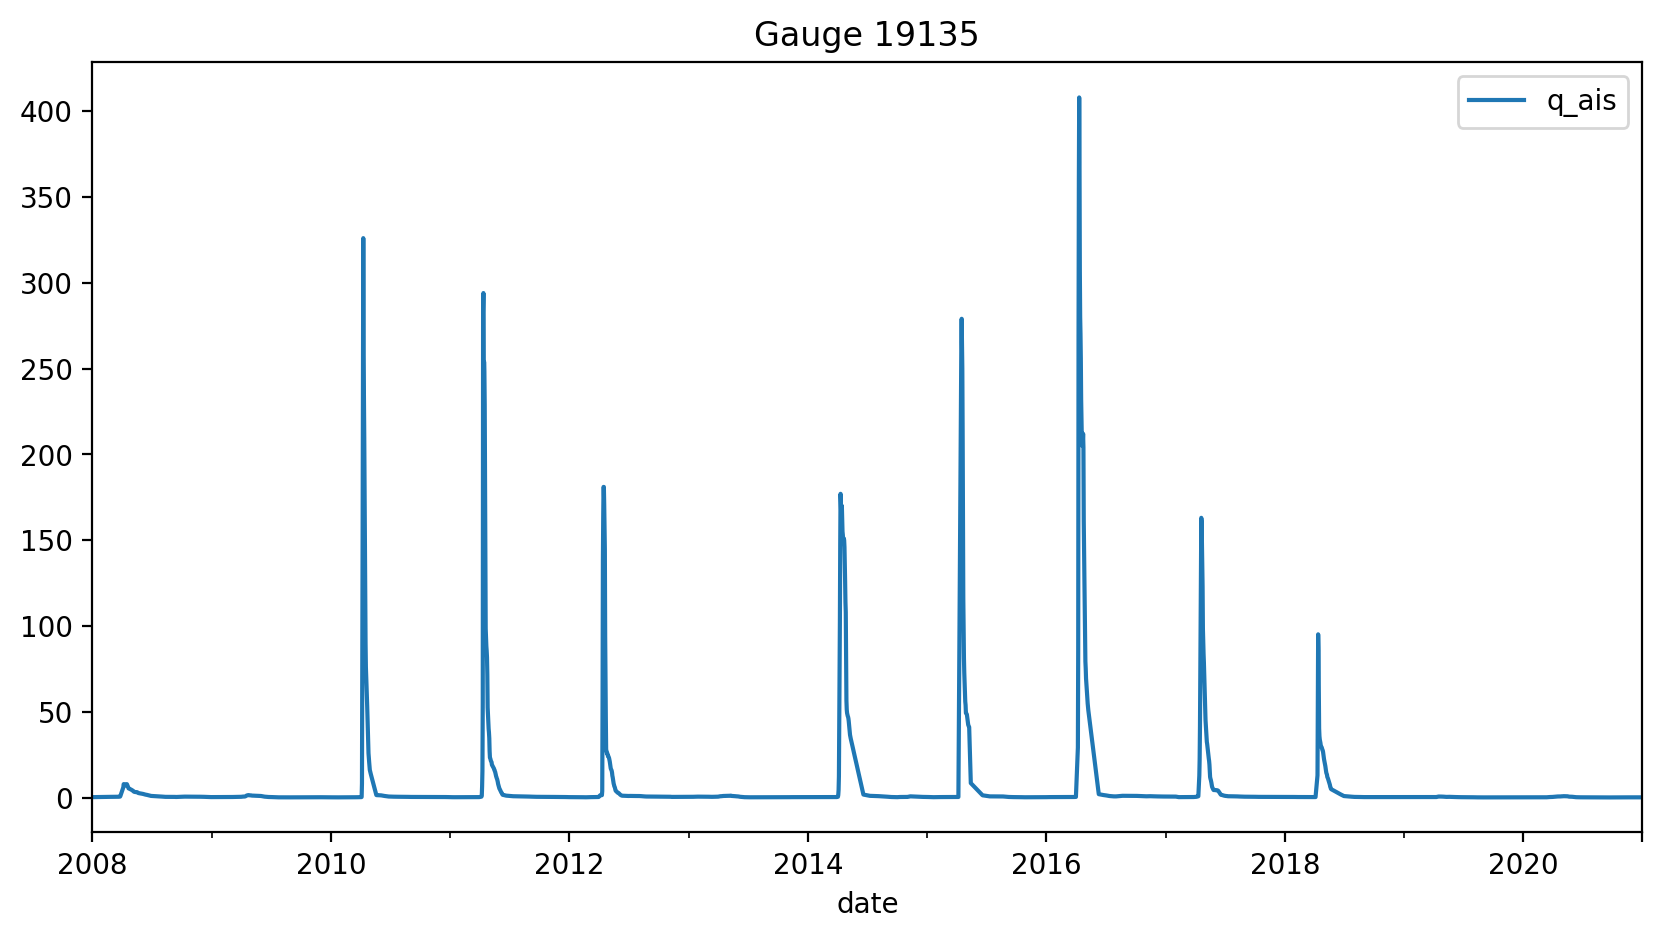

In [109]:
ais_gauges = {}
gauges = ["19135", "78261"]
# Example: Read a gauge file directly using the returned path
for gauge_id in gauges:
    file_path = check_gauge_location(gauge_id)

    df = pd.read_csv(file_path, parse_dates=["date"], index_col="date")
    df.rename(columns={"q_cms": "q_ais"}, inplace=True)
    ais_gauges[gauge_id] = df

    # df.loc["2008":, "q_cms"].plot(figsize=(10, 5));

ais_gauges["19135"].loc["2008":"2020", "q_ais"].plot(
    figsize=(10, 5), label="q_ais", legend=True, title="Gauge 19135"
);


In [98]:
shi_data = pd.read_csv(
    "../res/data-1767089456445.csv", index_col="date", parse_dates=True
)
shi_data["gauge_id"] = shi_data["gauge_id"].astype(str)

shi_gauges = {}
for gauge_id in gauges:
    shi_gauge = shi_data.loc[shi_data["gauge_id"] == gauge_id, :]
    shi_gauges[gauge_id] = shi_gauge.loc["2019":"2020", "runoff"]
    shi_gauges[gauge_id].rename({"runoff": "q_shi"}, inplace=True)

compare_df = {}
for gauge_id in gauges:
    compare_df[gauge_id] = pd.DataFrame(
        {
            "q_shi": shi_gauges[gauge_id],
            "q_cms": ais_gauges[gauge_id].loc["2019":"2020", "q_ais"],
        }
    )


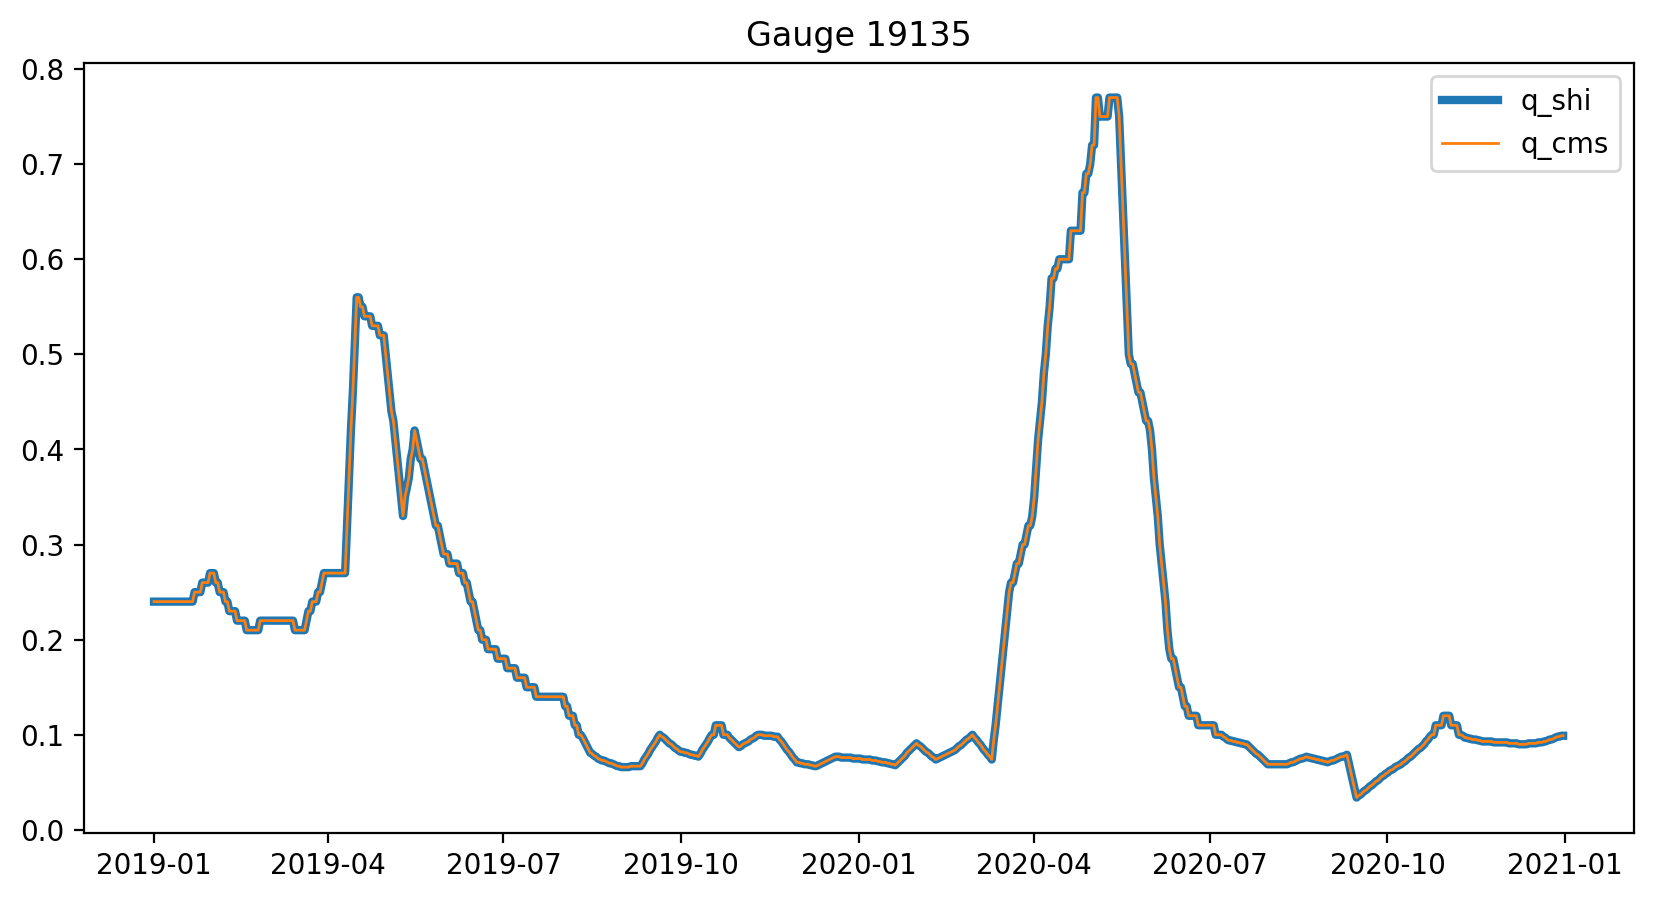

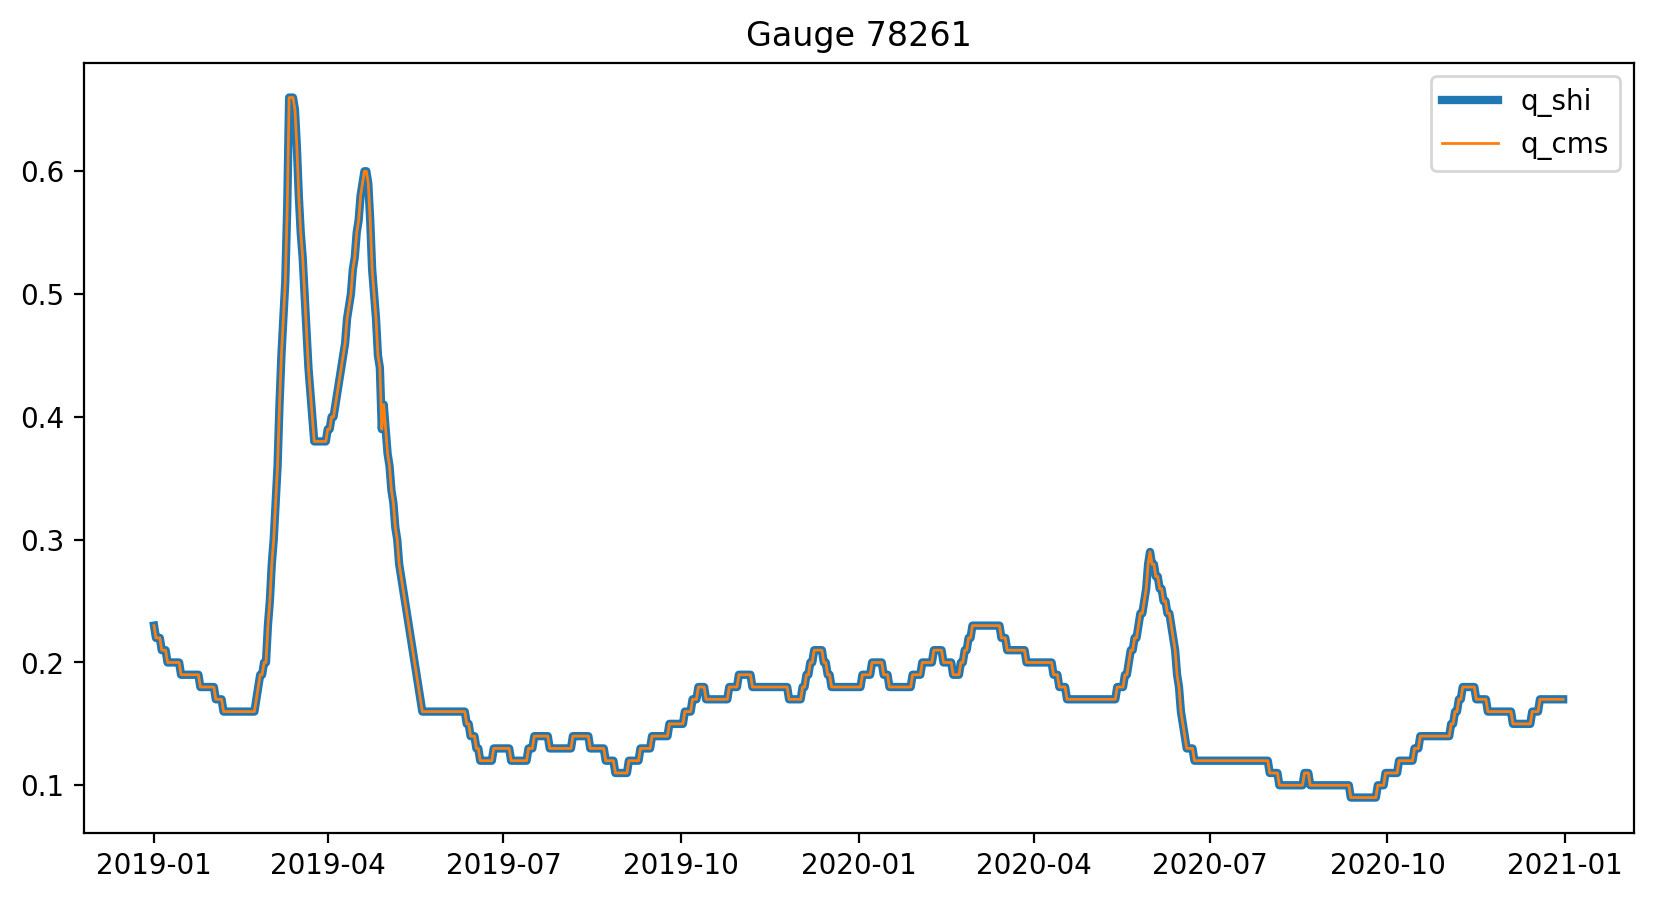

In [101]:
import matplotlib.pyplot as plt

for gauge_id in gauges:
    fig, ax = plt.subplots(figsize=(10, 5))
    # Plot 'runoff' first with thicker line (so it appears below 'q_cms')
    ax.plot(
        compare_df[gauge_id].index,
        compare_df[gauge_id]["q_shi"],
        linewidth=3,
        label="q_shi",
        zorder=1,
    )
    # Plot 'q_cms' second with thinner line (so it appears on top)
    ax.plot(
        compare_df[gauge_id].index,
        compare_df[gauge_id]["q_cms"],
        linewidth=1,
        label="q_cms",
        zorder=2,
    )
    ax.legend()
    ax.set_title(f"Gauge {gauge_id}")
    plt.show()


In [ ]:
# Check all gauges and log their locations
LOG.info("=" * 60)
LOG.info("Checking locations for all poor gauges")
LOG.info("=" * 60)

location_summary = {}
file_paths_summary = {}
for gauge_id in poor_gauges.index:
    gauge_id_str = str(gauge_id)
    file_path = check_gauge_location(gauge_id_str)
    if file_path:
        # Store the full path for easy access
        file_paths_summary[gauge_id_str] = str(file_path)
        # Extract location from path (e.g., "full/decent" from path)
        parts = file_path.parts
        location = f"{parts[-3]}/{parts[-2]}"  # e.g., "full/decent"
        location_summary[gauge_id_str] = location
    else:
        location_summary[gauge_id_str] = "not_found"
        file_paths_summary[gauge_id_str] = None

# Create a summary DataFrame
location_series = pd.Series(location_summary, name="location")
location_df = pd.DataFrame(location_series)
location_counts = location_df["location"].value_counts()

# Create DataFrame with file paths
file_paths_series = pd.Series(file_paths_summary, name="file_path")
paths_df = pd.DataFrame(file_paths_series)

LOG.info("\nLocation Summary:")
LOG.info(location_counts.to_string())

print("\nLocation Summary:")
print(location_counts)
print("\nDetailed locations:")
print(location_df)
print("\nFile paths (for direct pandas reading):")
print(paths_df)


2025-12-30 12:07:46 | INFO     | PhDLogger | tmpSeries | ℹ️  ============================================================
2025-12-30 12:07:46 | INFO     | PhDLogger | tmpSeries | ℹ️  Checking locations for all poor gauges
2025-12-30 12:07:46 | INFO     | PhDLogger | tmpSeries | ℹ️  ============================================================
2025-12-30 12:07:46 | INFO     | PhDLogger | tmpSeries | ℹ️  Gauge 19135 found in: full/decent


2025-12-30 12:07:46 | INFO     | PhDLogger | tmpSeries | ℹ️  Gauge 78261 found in: full/decent
2025-12-30 12:07:46 | INFO     | PhDLogger | tmpSeries | ℹ️  Gauge 19128 found in: full/decent
2025-12-30 12:07:46 | INFO     | PhDLogger | tmpSeries | ℹ️  Gauge 19127 found in: full/decent
2025-12-30 12:07:46 | INFO     | PhDLogger | tmpSeries | ℹ️  Gauge 78225 found in: full/decent
2025-12-30 12:07:46 | INFO     | PhDLogger | tmpSeries | ℹ️  Gauge 77270 found in: full/decent
2025-12-30 12:07:46 | INFO     | PhDLogger | tmpSeries | ℹ️  Gauge 78191 found in: full/decent
2025-12-30 12:07:46 | INFO     | PhDLogger | tmpSeries | ℹ️  Gauge 77336 found in: full/decent
2025-12-30 12:07:46 | INFO     | PhDLogger | tmpSeries | ℹ️  Gauge 77362 found in: full/decent
2025-12-30 12:07:46 | INFO     | PhDLogger | tmpSeries | ℹ️  Gauge 78231 found in: full/decent
2025-12-30 12:07:46 | INFO     | PhDLogger | tmpSeries | ℹ️  Gauge 78620 found in: full/decent
2025-12-30 12:07:46 | INFO     | PhDLogger | tmpSe


Location Summary:
location
full/decent       85
partial/decent     8
full/poor          5
partial/poor       2
Name: count, dtype: int64

Detailed locations:
           location
19135   full/decent
78261   full/decent
19128   full/decent
19127   full/decent
78225   full/decent
...             ...
75752   full/decent
78141   full/decent
84185  partial/poor
79244   full/decent
77164   full/decent

[100 rows x 1 columns]
